In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.set_default_dtype(torch.float64)

In [2]:
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            if spectral:
                self.dense[str(i)] = spectral_norm(nn.Linear(neurons[i], neurons[i+1]))
            else:
                self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            
            if activation==torch.sin:
                c = torch.sqrt(torch.tensor(6.))
                numerator = torch.sqrt(torch.tensor(neurons[i]).double())
                nn.init.uniform_(self.dense[str(i)].weight, a=-c/numerator, b=c/numerator)
                nn.init.zeros_(self.dense[str(i)].bias)
            else:
                nn.init.xavier_uniform_(self.dense[str(i)].weight)
                nn.init.zeros_(self.dense[str(i)].bias)                
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [3]:
device='cuda'
torch.manual_seed(0)

dim_x = 1
dim_z = 10
k_sensors = 41
f_sensors = 201
B_size=64
B_x = torch.randn([dim_x,B_size//2], device=device)
B_z = torch.randn([dim_z,B_size//2], device=device)

save_path='WGANSN_PCN_MD'
if not os.path.exists(save_path):
    os.makedirs(save_path)
with open(save_path+'/B_x.pickle', 'wb') as f:
    pickle.dump(B_x, f, pickle.HIGHEST_PROTOCOL)
with open(save_path+'/B_z.pickle', 'wb') as f:
    pickle.dump(B_z, f, pickle.HIGHEST_PROTOCOL)

p=64
net_size_ux = [B_size,64,64,p]
net_size_uz = [B_size,64,64,p]
net_size_kx = [B_size,64,64,p]
net_size_kz = [B_size,64,64,p]
net_size_taux = [B_size,64,64,p]
net_size_tauz = [B_size,64,64,p]
net_size_Dk = [k_sensors,64, 64, 64, 64,1]
net_size_Dtau = [f_sensors,64, 64, 64, 64,1]
net_size_Df = [f_sensors,64, 64, 64, 64,1]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

def FEz(x):
    x_sin = torch.sin(torch.matmul(x,B_z))
    x_cos = torch.cos(torch.matmul(x,B_z))
    return torch.concat([x_cos,x_sin],-1)

acti = torch.sin
ux = DNN(net_size_ux, activation=acti).to(device)
uz = DNN(net_size_uz, activation=acti).to(device)
taux = DNN(net_size_taux, activation=acti).to(device)
tauz = DNN(net_size_tauz, activation=acti).to(device)
kx = DNN(net_size_kx, activation=acti).to(device)
kz = DNN(net_size_kz, activation=acti).to(device)
Dk = DNN(net_size_Dk, activation=torch.relu, spectral=True).to(device)
Dtau = DNN(net_size_Dtau, activation=torch.relu, spectral=True).to(device)
Df = DNN(net_size_Df, activation=torch.relu, spectral=True).to(device)

def GU(X, Z):
    X_FE = FEx(X)
    Z = FEz(Z)
    outx = acti(ux(X_FE))*(X-1)*(X+1)
    outz = uz(Z)
    out = torch.matmul(outz,outx.T)
    return out

def GK(X,Z):
    X = FEx(X)
    Z = FEz(Z)
    outx = acti(kx(X))
    outz = uz(Z)#kz(Z)
    out = torch.matmul(outz,outx.T)
    return out

def Gtau(X,Z):
    X = FEx(X)
    Z = FEz(Z)
    outx = acti(taux(X))
    outz = uz(Z)#tauz(Z)
    out = torch.matmul(outz,outx.T)
    return out

def tautilde(X,Z):
    u = GU(X,Z)
    k = GK(X,Z).detach()
    tau = Gtau(X,Z)
    
    dummy = torch.ones(u.shape, device=device, requires_grad=True)
    tmp = grad(u, X, grad_outputs=dummy, create_graph=True)[0]
    u_x = grad(tmp[:,0].sum(), dummy, create_graph=True)[0]
    return k*u_x+tau
    
def ftilde(X,Z):
    tau = Gtau(X,Z)
    dummy = torch.ones(tau.shape, device=device, requires_grad=True)
    tmp = grad(tau, X, grad_outputs=dummy, create_graph=True)[0]
    tau_x = grad(tmp[:,0].sum(), dummy, create_graph=True)[0]
    return tau_x

In [4]:
with open('train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
    
N_train = 9000
x_k = torch.tensor(train_data['x_k'], device=device).T
x_f = torch.tensor(train_data['x_f'], device=device, requires_grad=True).T
k_data = torch.tensor(train_data['k'], device=device)[:N_train]
f_data = torch.tensor(train_data['f'], device=device)
f_data = f_data.repeat([N_train,1])

In [5]:
def compute_lossD(Z, K, F):
    TAU = torch.zeros(F.shape, device=device)
    
    K_gen = GK(x_k, Z)
    TAU_gen = tautilde(x_f, Z)
    F_gen = ftilde(x_f, Z)
    Dreal = Dk(K)+Dtau(TAU)+Df(F)
    Dfake = Dk(K_gen)+Dtau(TAU_gen)+Df(F_gen)
    lossD = Dreal.mean()-Dfake.mean()
    
    return -lossD

def compute_lossG(Z):
    K_gen = GK(x_k, Z)
    TAU_gen = tautilde(x_f, Z)
    F_gen = ftilde(x_f, Z)
    Dfake = Dk(K_gen)+Dtau(TAU_gen)+Df(F_gen)
    lossG = -Dfake.mean()
    return lossG

def updateD(Z,K,F):
    optimizerD.zero_grad()
    lossD = compute_lossD(Z,K,F)
    lossD.backward()
    optimizerD.step()

def updateG(Z):
    optimizerG.zero_grad()
    lossG = compute_lossG(Z)
    lossG.backward()
    optimizerG.step()

In [6]:
torch.manual_seed(0)

D_params = list(Dk.parameters())+list(Dtau.parameters())+list(Df.parameters())
G_params = list(ux.parameters())+list(uz.parameters()) + list(kx.parameters()) + list(taux.parameters())
optimizerD = torch.optim.RMSprop(D_params, lr=2e-4)
optimizerG = torch.optim.RMSprop(G_params, lr=5e-5)

num_epochs = 50000
st = time.time()
for epoch in range(num_epochs):
    z = torch.randn([N_train,dim_z], device=device)
    updateD(z, k_data, f_data)
    updateG(z)
torch.save(Dk.state_dict(), save_path+'/paramsDk')
torch.save(Dtau.state_dict(), save_path+'/paramsDtau')
torch.save(Df.state_dict(), save_path+'/paramsDf')
torch.save(ux.state_dict(), save_path+'/paramsux')
torch.save(uz.state_dict(), save_path+'/paramsuz')
torch.save(taux.state_dict(), save_path+'/paramstaux')
torch.save(tauz.state_dict(), save_path+'/paramstauz')
torch.save(kx.state_dict(), save_path+'/paramskx')
torch.save(kz.state_dict(), save_path+'/paramskz')

print(f"{time.time()-st} seconds")

1705.5942068099976 seconds


In [7]:
torch.manual_seed(0)

N_test = 20000
m_test = 201

with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)
x_test = torch.tensor(test_data['x'], device=device).T
with torch.no_grad():
    z_test = torch.randn([N_test,dim_z],device=device)
    u_gen = GU(x_test, z_test).cpu()
    u_mean, u_std = u_gen.mean(0), u_gen.std(0)

u_mean_ref = test_data['u_mean']
u_std_ref = test_data['u_std']

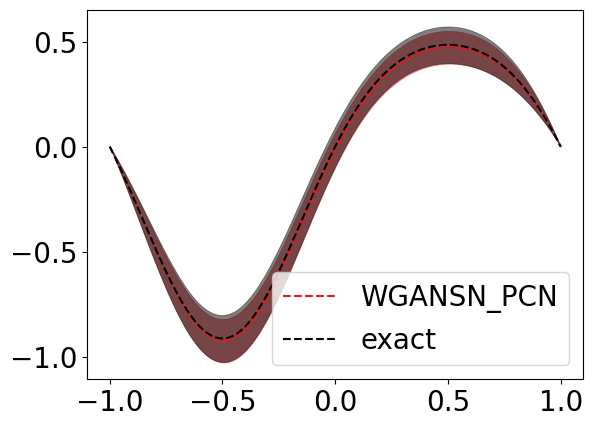

In [8]:
colors = [plt.cm.Paired(i) for i in range(20)]
x_test_ = x_test.flatten().cpu()

plt.plot(x_test_,u_mean,'--',label='WGANSN_PCN', color=colors[5])
plt.fill_between(x_test_, u_mean+u_std, u_mean-u_std, alpha=0.5, linewidth=.5, color=colors[5])

plt.plot(x_test_.flatten(),u_mean_ref, '--',label='exact', color='k')
plt.fill_between(x_test_, u_mean_ref+u_std_ref, u_mean_ref-u_std_ref, alpha=0.5, linewidth=.5, color='k')
plt.legend()

In [ ]:
!kill -9 {os.getpid()}